# Dask to deal with large datasets

Dask uses existing Python APIs and data structures to make you feel comfortable using its Numpy, Pandas and Scikit-learn equivalent tools. 

In this section, we use Dask Bag and Python JSON module to get initial findings from a large JSON data (9.2GB) of books. Dask Bag implements operations like *map*, *filter*, *fold*, and *groupby* on collections of generic Python objects. In the following, we are processing this data filtering records of interest, mapping functions to process the data and aggregating results to get meaningful values.

Importing packages:

In [1]:
import dask.bag as db
import pandas as pd
import numpy as np
import json

b = db.read_text('books/goodreads_books.json').map(json.loads)

Every book contains its own dictionary of information. Displaying the content of one dictionary, we know exactly how data looks and the name of the different keys. Taking 1 sample:

In [2]:
b.take(1)

({'isbn': '0312853122',
  'text_reviews_count': '1',
  'series': [],
  'country_code': 'US',
  'language_code': '',
  'popular_shelves': [{'count': '3', 'name': 'to-read'},
   {'count': '1', 'name': 'p'},
   {'count': '1', 'name': 'collection'},
   {'count': '1', 'name': 'w-c-fields'},
   {'count': '1', 'name': 'biography'}],
  'asin': '',
  'is_ebook': 'false',
  'average_rating': '4.00',
  'kindle_asin': '',
  'similar_books': [],
  'description': '',
  'format': 'Paperback',
  'link': 'https://www.goodreads.com/book/show/5333265-w-c-fields',
  'authors': [{'author_id': '604031', 'role': ''}],
  'publisher': "St. Martin's Press",
  'num_pages': '256',
  'publication_day': '1',
  'isbn13': '9780312853129',
  'publication_month': '9',
  'edition_information': '',
  'publication_year': '1984',
  'url': 'https://www.goodreads.com/book/show/5333265-w-c-fields',
  'image_url': 'https://images.gr-assets.com/books/1310220028m/5333265.jpg',
  'book_id': '5333265',
  'ratings_count': '3',
  'w

In [3]:
print(type(b))

<class 'dask.bag.core.Bag'>


Now, we know that there is information about language, publication date, author, title, format, description of the book and more. If you have an idea about what are you exactly looking for, you can reduce the size of this bag selecting only the useful columns. This is specially practical if you create a DataFrame later.

Here, we retrieve some keys, listed to following, in the method `flatten`.

In [4]:
def flatten(record):
    return {
        'text_reviews_count': record['text_reviews_count'],
        'language_code': record['language_code'],
        'is_ebook': record['is_ebook'],
        'average_rating': record['average_rating'],
        'kindle_asin': record['kindle_asin'],
        'description': record['description'],
        'format': record['format'],
        'authors': record['authors'],
        'publisher': record['publisher'],
        'num_pages': record['num_pages'],
        'publication_day': record['publication_day'],
        'publication_month': record['publication_month'],
        'publication_year': record['publication_year'],
        'book_id': record['book_id'],
        'ratings_count': record['ratings_count'],
        'title': record['title'],
        'title_without_series': record['title_without_series']
    }

Taking 10 items, but displaying the second one:

In [5]:
b.map(flatten).take(10)[1]

{'text_reviews_count': '6',
 'language_code': '',
 'is_ebook': 'false',
 'average_rating': '3.23',
 'kindle_asin': 'B000FC0PBC',
 'description': 'Anita Diamant\'s international bestseller "The Red Tent" brilliantly re-created the ancient world of womanhood. Diamant brings her remarkable storytelling skills to "Good Harbor" -- offering insight to the precarious balance of marriage and career, motherhood and friendship in the world of modern women. The seaside town of Gloucester, Massachusetts is a place where the smell of the ocean lingers in the air and the rocky coast glistens in the Atlantic sunshine. When longtime Gloucester-resident Kathleen Levine is diagnosed with breast cancer, her life is thrown into turmoil. Frightened and burdened by secrets, she meets Joyce Tabachnik -- a freelance writer with literary aspirations -- and a once-in-a-lifetime friendship is born. Joyce has just bought a small house in Gloucester, where she hopes to write as well as vacation with her family. Li

Applying `flatten` method to all the dataset:

In [6]:
d = b.map(flatten)

The number of records is:

In [7]:
%%time
b.count().compute() 

CPU times: user 69.3 ms, sys: 53.4 ms, total: 123 ms
Wall time: 1min 30s


2360655

### The powerfull of Dask Bag

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

### 1. Distribution of languages

In [9]:
languages = d.map(lambda h: h['language_code']).frequencies(sort=True).compute()

Extracting the most popular languages (filtering languages lower than one thousand of books):

In [10]:
top_languages = list(filter(lambda l: l[1] > 1000 and l[0] != '' ,languages))

In [11]:
language, count = zip(*top_languages)

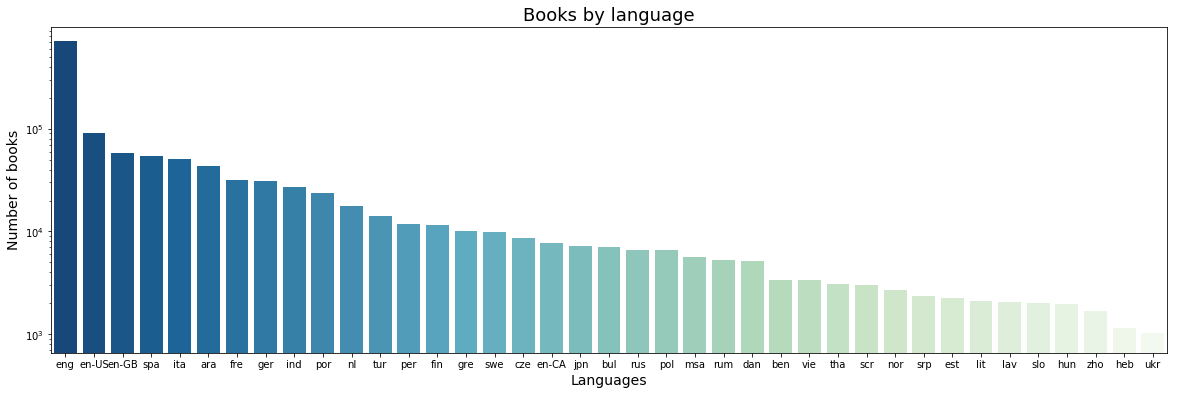

In [12]:
fig, ax = plt.subplots(figsize=(20,6))

# Set the scale of the x-and y-axes
ax.set(yscale="log")

# Create a barplot
sns.barplot(list(language), count, ax=ax, palette='GnBu_r')
plt.xlabel('Languages', fontsize=14)
plt.ylabel('Number of books', fontsize=14)
plt.title('Books by language', fontsize=18)

# Show plot
plt.show()

Now, we build a dataframe with the information of books by languages with the method `to_dataframe` of Dask. Hereafter, we can use some the known dataframes methods that we are learning working with Pandas.

In [13]:
db_languages = d.map(lambda h: h['language_code']).frequencies(sort=True).to_dataframe()

Adding appropiate labels for the columns:

In [14]:
db_languages.columns = ['language', 'books']

And deleting the column with missing information about the language:

In [15]:
db_languages = db_languages[db_languages.language != ''].dropna()

The most popular languages are:

In [16]:
db_languages.head(10)

,language,books
1,eng,708457
2,en-US,91452
3,en-GB,58358
4,spa,54524
5,ita,50902
6,ara,42978
7,fre,32046
8,ger,30941
9,ind,27291
10,por,23452


### 2. Publication Date

In this case, we apply a `flatten_year` function to extract `book_id` and `publication_year`. We group countries according to the publication year and then we display the results along the time.

In [17]:
def flatten_year(record):
    return {
        'book_id': record['book_id'],
        'publication_year': record['publication_year']
    }

In [18]:
publication = d.map(lambda h: h['publication_year']).frequencies()

Filtering missing data:

In [19]:
pubYear = list(filter(lambda l: l[0] != '', publication))

Now, with a significant reduction of data, we can easily manage this information in Pandas DataFrame. Converting the list to DataFrame:

In [20]:
df = pd.DataFrame(pubYear, columns =['year', 'books'])

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 740 entries, 0 to 739
Data columns (total 2 columns):
year     740 non-null object
books    740 non-null int64
dtypes: int64(1), object(1)
memory usage: 11.6+ KB


In [22]:
df['year'] = df.year.astype(int)

To study the evolution of publications along the time, we check the validy of values in the DataFrame, displaying a boxplot to detect outliers or anomally values visually:

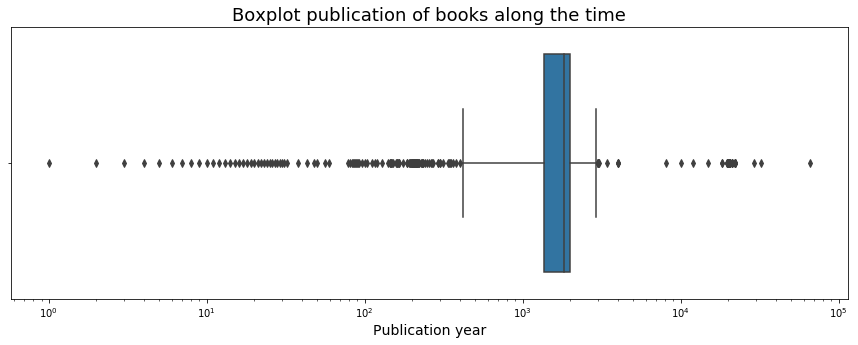

In [23]:
fig, ax = plt.subplots(figsize=(15,5))

_ = ax.set(xscale="log")
_ = sns.boxplot(x='year', data=df, ax=ax)
_ = plt.xlabel('Publication year', fontsize=14)
_ = plt.title('Boxplot publication of books along the time', fontsize=18)

plt.show()

This is a very interesting result. It's impossible to anticipate future publications and we assert that every publication year more than 2017 is an invalid value, because it doesn't make sense. But what about anciant literature? The **oldest book in the world** belongs to the Etruscan civilization and it is 2500 years old. After that, different cultural expressions -Bible, religious and scientific manuscripts- have been developed and luckely preserved until now.

To analyze a reasonable period of time, we inspect the percentiles 25 and 75-80 from data:

In [24]:
print('Percentile 25% : {}'.format(np.percentile(df['year'], 25)))
print('Percentile 77% : {}'.format(np.percentile(df['year'], 77)))

Percentile 25% : 1362.75
Percentile 77% : 2017.03


In [25]:
df_year = df[(df['year'] > np.percentile(df['year'], 25)) & (df['year'] < np.percentile(df['year'], 77))]

In [26]:
df_year.head()

,year,books
0,1984,5791
1,2001,28229
2,1987,7568
3,2009,77452
4,2006,51178


The **historical publication** of books in the selected period is displaying as following:

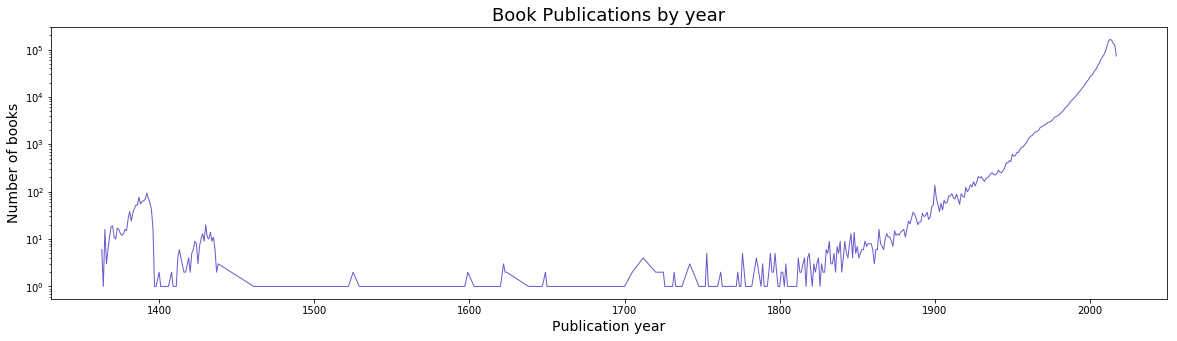

In [27]:
fig, ax = plt.subplots(figsize=(20,5))

_ = ax.set(yscale="log")
_ = sns.lineplot(x='year', y='books', data=df_year, palette="tab10", ax=ax, linewidth=1, color='slateblue')
_ = plt.xlabel('Publication year', fontsize=14)
_ = plt.ylabel('Number of books', fontsize=14)
_ = plt.title('Book Publications by year', fontsize=18)

plt.show()

And finally, displaying the **moving average** (using rolling windows of 50 years):

/Users/daniela/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


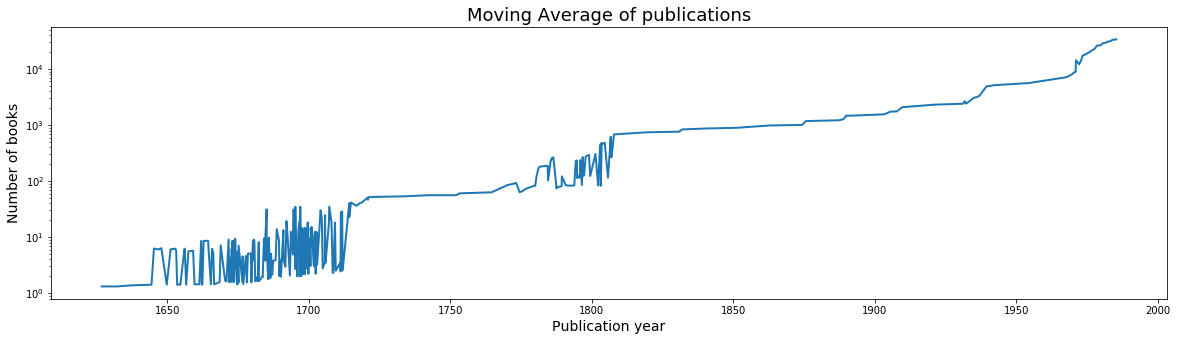

In [28]:
data = df_year.rolling(50).mean()

fig, ax = plt.subplots(figsize=(20,5))
_ = ax.set(yscale="log")
_ = sns.lineplot(x='year', y='books', data=data, ax=ax, linewidth=2)
_ = plt.xlabel('Publication year', fontsize=14)
_ = plt.ylabel('Number of books', fontsize=14)
_ = plt.title('Moving Average of publications', fontsize=18)

plt.show()

### 3. Formats, publishers and number of pages

**Bag** objects allow us mapping and filtering information. For instances, the top then types of format used are:

In [29]:
d.filter(lambda h: h['format'] != '').map(lambda h: h['format']).frequencies(sort=True).topk(10, key=1).compute()

[('Paperback', 894617),
 ('Hardcover', 359563),
 ('ebook', 188733),
 ('Kindle Edition', 125566),
 ('Mass Market Paperback', 42224),
 ('Audio CD', 30588),
 ('Audiobook', 17387),
 ('Audible Audio', 11073),
 ('Audio', 8335),
 ('Unknown Binding', 8126)]

The same exercise, but for publishes:

In [30]:
d.filter(lambda h: h['publisher'] != '').map(lambda h: h['publisher']).frequencies(sort=True).topk(10, key=1).compute()

[('Createspace Independent Publishing Platform', 18604),
 ('Smashwords Edition', 11513),
 ('Harlequin', 10300),
 ('Createspace', 9688),
 ('HarperCollins', 8173),
 ('Penguin Books', 7429),
 ('Oxford University Press, USA', 6741),
 ('Brilliance Audio', 6350),
 ('Vintage', 6338),
 ('Berkley', 5546)]

In [31]:
df = d.to_dataframe()

In [32]:
df_ratings_pages = df.loc[:, ['book_id', 'num_pages', 'average_rating']]

In [33]:
df_ratings_pages['num_pages'] = df_ratings_pages.num_pages.astype(int)
df_ratings_pages['average_rating'] = df_ratings_pages.average_rating.astype(float)

In [34]:
df_ratings_pages.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 3 entries, book_id to average_rating
dtypes: object(1), float64(1), int64(1)

In [35]:
df_ratings_pages[df_ratings_pages.num_pages < 10]

,book_id,num_pages,average_rating
npartitions=1,,,
,object,int64,float64
,...,...,...
